Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
import sys
sys.executable
#!which python #which does not semm to work on windows

'C:\\Users\\moritz\\anaconda3\\envs\\social-2\\python.exe'

# Install dependencies:

In [2]:
install_packages = False
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge html2text -y
    !conda install -c conda-forge tensorflow-hub -y # !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y
    print("Done")

# Imports

In [3]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [21]:
path = os.path.abspath("..")
data_path = path + "\\data_raw\\all_comments.csv"

output_path = "./output/"

print("input path: " + data_path)

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'DAN' #@param ['DAN','Transformer','Transformer_Multilingual']

input path: C:\Users\moritz\Downloads\social analizing\project\git\social_media_youtube_analysis_project\data_raw\all_comments.csv


## Create output directory
Try to create the directory defined by output_path

In [22]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [23]:
if new_embeddings:
    data = pd.read_csv(data_path,header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [24]:
if new_embeddings:
    data = data.dropna(subset=['text', 'author_name']) # drop rows with no content
    data=data.drop(['id','likeCount'],axis=1)#, 'replyCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'] # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [25]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['author_name'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|███████████████████████████████████████████████████████████████████████████| 9683/9683 [00:00<00:00, 11535.74it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [26]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,Unnamed: 0,threadId,published_at,author_name,text,is_reply,cleaned,video_id,video_published_at
0,0,UgzORANz-QqEpp_NTDd4AaABAg,2021-02-04T14:43:02Z,Casey Foy,I do know something needs to be done all the earthquakes volcanoes flooding tornadoes even the snow we got more then usual. My mom seen a video on TV that oneday they will have to really focus on this. I seen our country is not so much the problem other countries are worse then ours. But we can always do what we can to help our earth.,0.0,I do know needs to be done all the earthquakes volcanoes flooding\ntornadoes even the snow we got more then usual. My mom seen a video on TV that\noneday they will have to really focus on this. I seen our country is not so\nmuch the problem other countries are worse then ours. But we can always do\nwhat we can to help our earth.\n\n,k1oPVp63eNk,NaN
1,1,UgyZV_VSA0J5mo7E6Gl4AaABAg,2021-02-03T20:23:48Z,Animals with Tomek,Even one Celcius degree more makes the African wild dogs have less pups! So we have to limit the increase of temperature.,0.0,Even one Celcius degree more makes the African wild dogs have less pups! So we\nhave to limit the increase of temperature.\n\n,k1oPVp63eNk,NaN
2,2,UgyLv1kdSZ2B8OhXr5x4AaABAg,2021-01-31T21:46:30Z,Matthew Richard,UK has lowered its emissions by a third since Paris.,0.0,UK has lowered its emissions by a third since Paris.\n\n,k1oPVp63eNk,NaN
3,3,UgxLNu-NE8QBvOPsk514AaABAg,2021-01-28T16:33:02Z,Andrew,"There is no ""CRISIS"". The biggest issue w this topic, is that most people conflate the environment w Climate Change. Yes, we ALL want to have clean water, clean air - but we cannot control the temp of the planet. The main driving force of that is NOT Man.",0.0,"There is no ""CRISIS"". The biggest issue w this topic, is that most people\nconflate the environment w Climate Change. Yes, we ALL want to have clean\nwater, clean air - but we cannot control the temp of the planet. The main\ndriving force of that is NOT Man.\n\n",k1oPVp63eNk,NaN
4,4,UgxLNu-NE8QBvOPsk514AaABAg,2021-02-03T21:08:59Z,Andrew,"@YraxZovaldo that sounds like a very scientific response 😃\nI think you may benefit from reading up a bit more on this subject. Don't get your info from MSM.\nPlenty of factual, scientic info, from Climate Experts, out there- if you go look for it....with an OPEN mind",1.0,"@ that sounds like a very scientific response 😃 I think you may\nbenefit from reading up a bit more on this subject. Don't get your info from\nMSM. Plenty of factual, scientic info, from Climate Experts, out there- if you\ngo look for it....with an OPEN mind\n\n",k1oPVp63eNk,NaN


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [27]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [28]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 The embeddings vector is of fixed length 512


TensorShape([9683, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[1.0000001  0.18648897 0.12007856 ... 0.20715514 0.3323246  0.08807059]
 [0.18648897 0.99999976 0.05149069 ... 0.03287233 0.11378209 0.08108065]
 [0.12007856 0.05149069 1.         ... 0.20166531 0.20372054 0.07250679]
 ...
 [0.20715514 0.03287233 0.20166531 ... 0.9999999  0.37336153 0.14946935]
 [0.3323246  0.11378209 0.20372054 ... 0.37336153 1.0000002  0.07230518]
 [0.08807059 0.08108065 0.07250679 ... 0.14946935 0.07230518 1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

C:\Users\moritz\anaconda3\envs\social-2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\moritz\anaconda3\envs\social-2\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128180 missing from current font.
  font.set_text(s, 0, flags=flags)


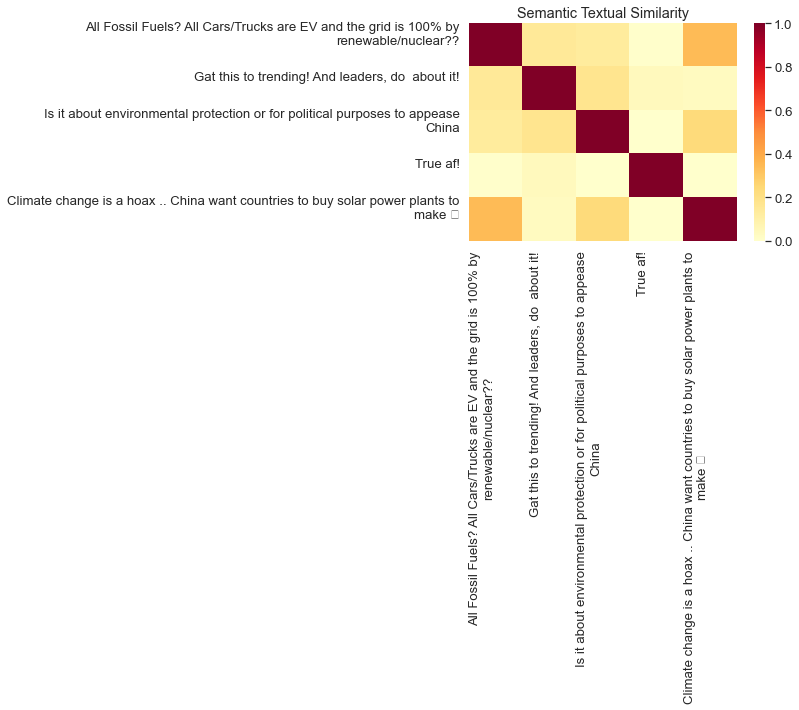

In [30]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 170

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [31]:
comment_index = 171
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Gat this to trending! And leaders, do  about it!




Print similar comments.

In [32]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Gat this to trending! And leaders, do  about it!


Top similar comment 2: Gat this to trending! And leaders, do  about it!


Top similar comment 3: Gat this to trending! And leaders, do  about it!


Top similar comment 4: Gat this to trending! And leaders, do  about it!


Top similar comment 5: @ What leaders and how do they do that exactly?


Top similar comment 6: @ What leaders and how do they do that exactly?


Top similar comment 7: @ What leaders and how do they do that exactly?


Top similar comment 8: @ What leaders and how do they do that exactly?


Top similar comment 9: Hmm..why don't the global leaders sit down and come to a unanimous agreement
to improve humanity..


Top similar comment 10: Hmm..why don't the global leaders sit down and come to a unanimous agreement
to improve humanity..


Top similar comment 11: American Leadership at its best! Boycott MSM


Top similar comment 12: All these leaders are left-wingers who were counting on extra cash f